In [2]:
import pickle
#import utils, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 50)

## Out-of-bag (OOB) score

In [40]:
def score():
    print(f'Scores:')
    print(f'Train      = {m.score(x_train, y_train):.4}')
    print(f'Validation = {m.score(x_val, y_val):.4}')
    if hasattr(m, 'oob_score_'): print(f'OOB        = {m.oob_score_:.4}') 

# [Diamonds](https://www.kaggle.com/shivam2503/diamonds/home)

- **price** price in US dollars (\$326--\$18,823) (target)

- **carat** weight of the diamond (0.2--5.01)

- **cut** quality of the cut (Fair, Good, Very Good, Premium, Ideal)

- **color** diamond colour, from J (worst) to D (best)

- **clarity** a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

- **x** length in mm (0--10.74)

- **y** width in mm (0--58.9)

- **z** depth in mm (0--31.8)

- **depth** total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

- **table** width of top of diamond relative to widest point (43--95)


## Reading

In [5]:
df_raw = pd.read_csv('data/diamonds.csv')
df_raw.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Analyzing 

#### Uniqueness

In [10]:
df_raw.nunique()/len(df_raw)

Unnamed: 0    1.000000
carat         0.005061
cut           0.000093
color         0.000130
clarity       0.000148
depth         0.003411
table         0.002354
price         0.215091
x             0.010271
y             0.010234
z             0.006952
dtype: float64

#### Categorical columns

In [14]:
[c for c in df_raw if not pd.api.types.is_numeric_dtype(df_raw[c])]

['cut', 'color', 'clarity']

#### Price column

In [21]:
df_raw['price'].describe()

count    53940.000000
mean      3932.799722
std       3989.439738
min        326.000000
25%        950.000000
50%       2401.000000
75%       5324.250000
max      18823.000000
Name: price, dtype: float64

## Preprocessing

#### Drop id column

In [16]:
df_raw.drop('Unnamed: 0', axis=1, inplace=True)

#### To categorical

In [17]:
categories_dict = {}

for n,col in df_raw.items():
    if not pd.api.types.is_numeric_dtype(col) and n != 'label':
        df_raw[n] = col.astype('category')
        categories_dict[n] = {i+1:e for i,e in enumerate(df_raw[n].cat.categories)}

In [19]:
df = df_raw.copy()

for n,col in df.items():
    if pd.api.types.is_categorical_dtype(col):
        df[n] = col.cat.codes+1

#### Price to log(price)

In [22]:
df.price = np.log(df.price)

#### Result

In [23]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,3,2,4,61.5,55.0,5.786897,3.95,3.98,2.43
1,0.21,4,2,3,59.8,61.0,5.786897,3.89,3.84,2.31
2,0.23,2,2,5,56.9,65.0,5.789960,4.05,4.07,2.31
3,0.29,4,6,6,62.4,58.0,5.811141,4.20,4.23,2.63
4,0.31,2,7,4,63.3,58.0,5.814131,4.34,4.35,2.75


## Analyzing target column (price)


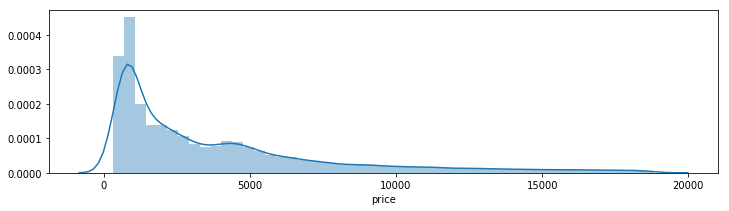

In [107]:
plt.figure(figsize=(12,3))
sns.distplot(df_raw.price);

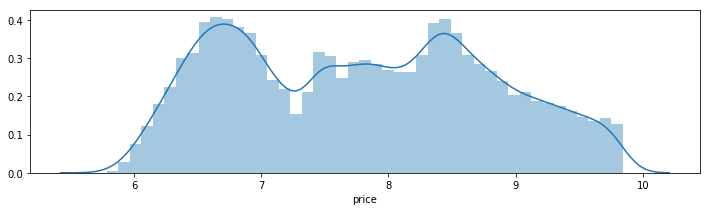

In [108]:
plt.figure(figsize=(12,3))
sns.distplot(np.log(df_raw.price));

In [53]:
df.price = np.log(df.price)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,3,2,4,61.5,55.0,0.562809,3.95,3.98,2.43
1,0.21,4,2,3,59.8,61.0,0.562809,3.89,3.84,2.31
2,0.23,2,2,5,56.9,65.0,0.563110,4.05,4.07,2.31
3,0.29,4,6,6,62.4,58.0,0.565187,4.20,4.23,2.63
4,0.31,2,7,4,63.3,58.0,0.565479,4.34,4.35,2.75


## Splitting data

In [42]:
from sklearn.model_selection import train_test_split

x = df.drop('price', axis=1)
y = df['price']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train shape      : {x_train.shape}')
print(f'Validation shape : {x_val.shape}')
print(f'Testt shape      : {x_test.shape}')

Train shape      : (32364, 9)
Validation shape : (10788, 9)
Testt shape      : (10788, 9)


## Training one regression tree

In [44]:
from sklearn.tree import DecisionTreeRegressor

m = DecisionTreeRegressor(max_depth=3)
m.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [45]:
score()

Scores:
Train      = 0.9277
Validation = 0.9263


In [34]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, m.predict(x_train)), mean_squared_error(y_val, m.predict(x_val))

(0.074481364842747658, 0.075971654071614561)

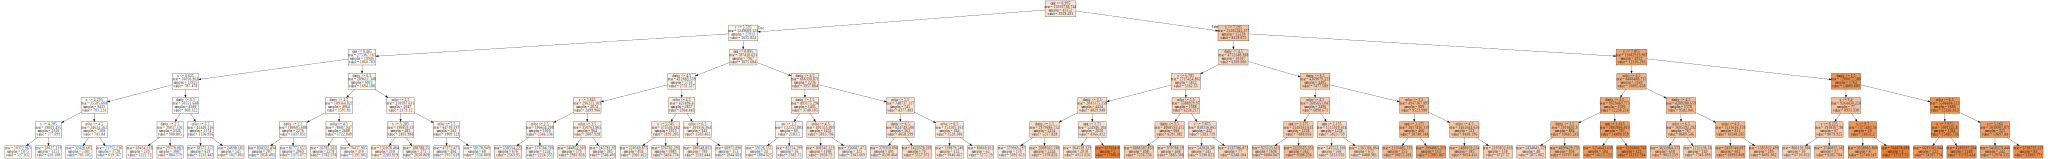

In [115]:
utils.draw_tree(m, x_train)

## Training a forest

In [35]:
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor(40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [36]:
score()

Scores:
Train      = 0.9987
Validation = 0.9908
OOB        = 0.9907


## Feature importance

### Sklearn feature importance (mean decrease impurity)

In [46]:
m.feature_importances_

array([ 0.0712774 ,  0.        ,  0.        ,  0.00250143,  0.        ,
        0.        ,  0.00752886,  0.91869231,  0.        ])

In [47]:
imp = pd.DataFrame({'cols':x_train.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
imp.style.bar()

,cols,imp
7,y,0.918692
0,carat,0.0712774
6,x,0.00752886
3,clarity,0.00250143
1,cut,0
2,color,0
4,depth,0
5,table,0
8,z,0


### Permutation importance

In [37]:
%%time
from rfpimp import importances, plot_importances

imp = importances(m, x_val, y_val)
plot_importances(imp, figsize=(5,9));

ModuleNotFoundError: No module named 'rfpimp'

### Drop-column importance

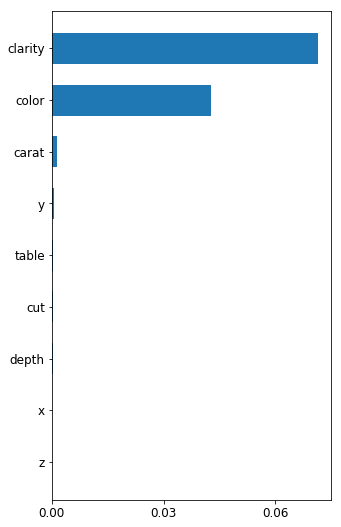

CPU times: user 1min 16s, sys: 390 ms, total: 1min 16s
Wall time: 12.8 s


In [121]:
%%time
from rfpimp import dropcol_importances

imp = dropcol_importances(m, x_train, y_train)
plot_importances(imp, figsize=(5,9));

## Partial Dependence Plot

In [38]:
from pdpbox import pdp, info_plots

df_train = x_train.assign(price=y_train)
df_train.head(2)

ModuleNotFoundError: No module named 'pdpbox'

### Examinemos la variable "clarity"

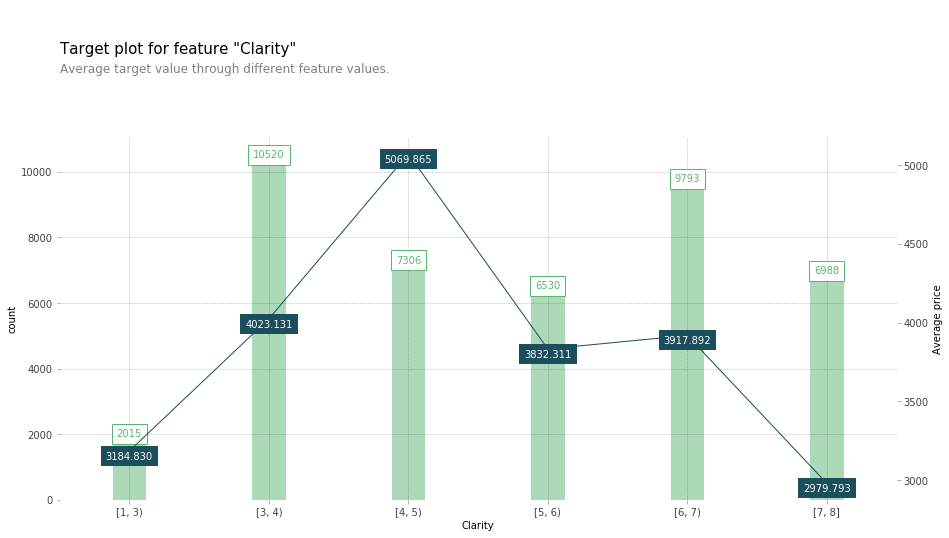

In [123]:
# Veamos como se distribuye en la data que tenemos, con respecto a nuestro target
info_plots.target_plot(df_train, 'clarity', 'Clarity', 'price');

In [125]:
cat_dict['clarity']

{1: 'I1',
 2: 'IF',
 3: 'SI1',
 4: 'SI2',
 5: 'VS1',
 6: 'VS2',
 7: 'VVS1',
 8: 'VVS2'}

In [126]:
# Ahora veamos como reacciona el modelo a esta variable
pdp_color = pdp.pdp_isolate(m, x_train, x_train.columns, 'clarity')

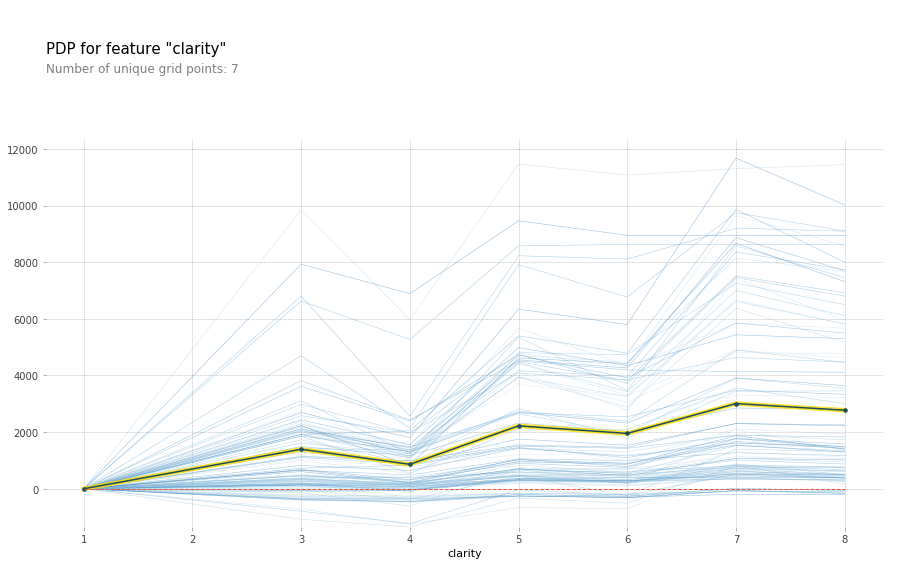

In [127]:
pdp.pdp_plot(pdp_color, 'clarity', plot_lines=True, frac_to_plot=100);

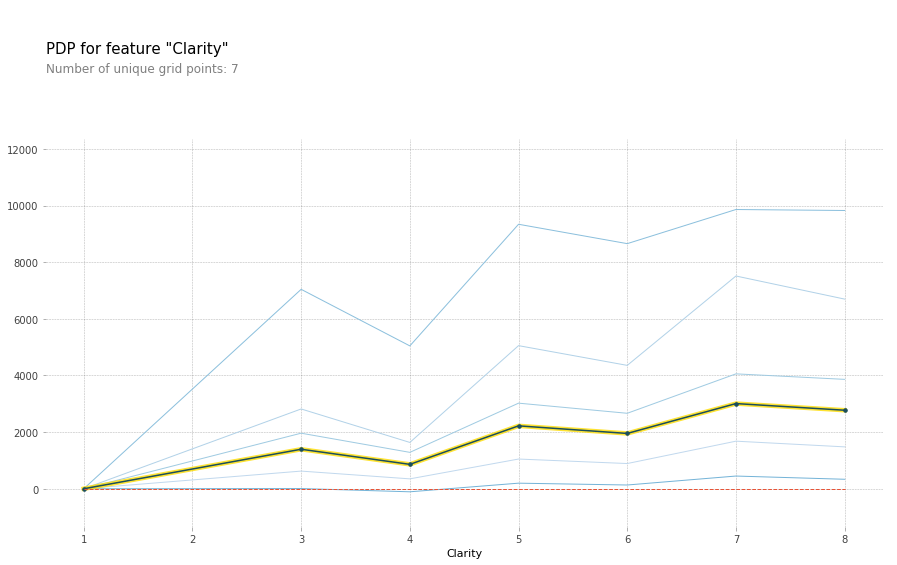

In [129]:
# Usamos la opción de clusters para agrupar mejor los comportamientos
fig, axes = pdp.pdp_plot(pdp_color, 'Clarity', cluster=True, n_cluster_centers=5)


### Veamos las interacciones entre longitud y latitud

In [130]:
pdp_x_y = pdp.pdp_interact(m, x_train, x_train.columns, ['x', 'y'])

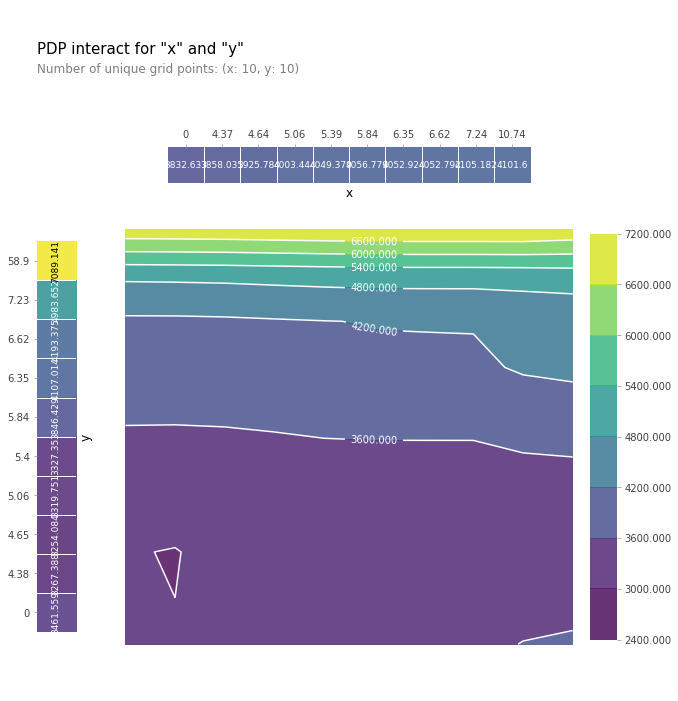

In [131]:
pdp.pdp_interact_plot(pdp_x_y, ['x', 'y'], plot_pdp=True);

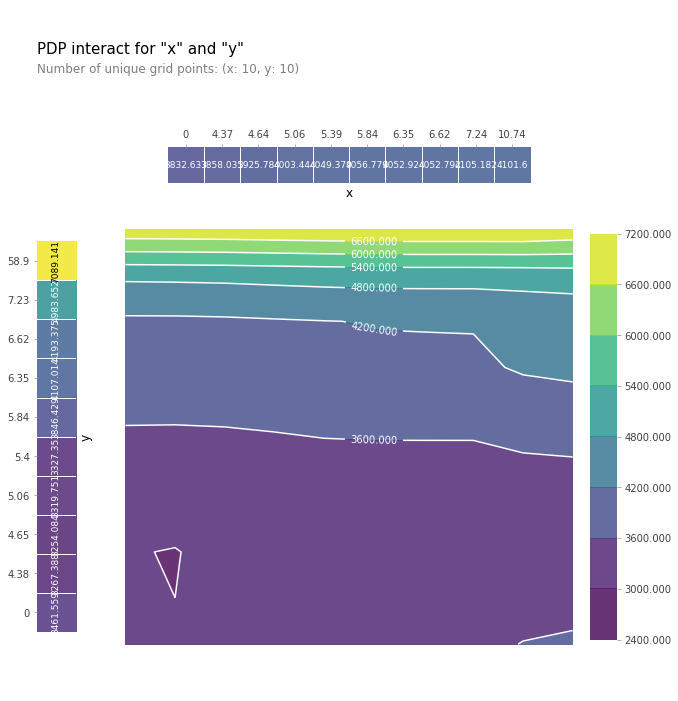

In [135]:
pdp.pdp_interact_plot(pdp_x_y, ['x', 'y'], plot_pdp=True);

## Tree interpreter

In [136]:
from treeinterpreter import treeinterpreter as ti

sample = x_val.sample()
print(f'Real price = {y_val[sample.index[0]]}')
sample

Real price = 7226


,carat,cut,color,clarity,depth,table,x,y,z
17896,1.01,5,4,8,59.7,59.0,6.5,6.56,3.9


In [137]:
preds, bias, contributions = ti.predict(m, sample)

In [138]:
# Predicción final
preds

array([7101.025])

In [139]:
# Bias inicial
bias

array([3939.41381222])

In [140]:
# Contribuciones de cada variable
contributions

array([[ 3039.9569847 ,   -89.03126286,  -570.23244322,  3299.35800924,
          123.02892616,  -162.50730827,   -95.9934061 , -2124.0538999 ,
         -258.91441198]])

In [141]:
# Veamos las contribuciones con el nombre de las variables
tt = pd.DataFrame(contributions, columns=sample.columns).T.sort_values(0)
tt.style.background_gradient(cmap='YlOrRd')

,0
y,-2124.05
color,-570.232
z,-258.914
table,-162.507
x,-95.9934
cut,-89.0313
depth,123.029
carat,3039.96
clarity,3299.36


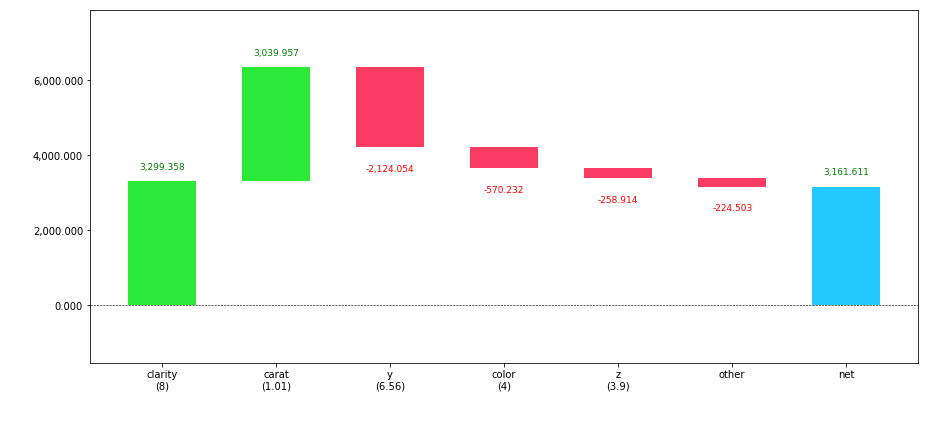

In [142]:
# Usamos un waterfallplot para tener una mejor visualización de la predicción
utils.waterfallplot(sample, contributions[0], formatting='{:,.3f}', size=(13,6), sorted_value=True, threshold=0.05);